# Zinser data (calibrated)

In [1]:
import netCDF4 as nc4
import numpy as np

# load data
datafile = 'Zinser_calibrated_m26.nc'

data_gridded = {}
with nc4.Dataset(datafile) as nc:
    for var in nc.variables:
        data_gridded[var] = nc.variables[var][:]

In [2]:
v_min = data_gridded['v_min']
delta_v = 1.0/data_gridded['delta_v_inv']
v = v_min * 2**(np.arange(data_gridded['m'])*delta_v) 

# The model

modified from *Sosik et al. (2003), Growth rates of coastal phytoplankton from time-series measurements with a submersible flow cytometer, Limnol. Oceanogr.*

In [3]:
stan_code = '''data {
    // size variables
    int<lower=0> m;         // number of size classes
    int<lower=0> nt;        // number of timesteps
    int<lower=0> nt_obs;    // number of timesteps with observations
    
    // model parameters and input
    int<lower=0> dt;        // delta t in minutes
    real<lower=0> E[nt];    // vector of incident radiation values
    real<lower=0> v_min;    // size in smallest size class in um^-3
    int<lower=0> delta_v_inv;  // inverse of delta_v 
    
    // observations
    real<lower=0,upper=nt*dt>  t_obs[nt_obs]; // the time of each observation
    matrix[m, nt_obs] obs; //observations
    
    // validation
    int<lower=0,upper=1> i_test[nt_obs];
}
transformed data {
    int j;
    int min_obs = 0;
    int max_obs = 0;
    int temp = 1;
    real<lower=0> delta_v;
    real<lower=0> dt_days;  // dt in units of days
    real<lower=0> dt_norm;  // dt in units of days and doublings
    real<lower=0> v[m+1];   // vector of (minimum) sizes for each size class
    int<lower=0> t[nt];     // vector of times in minutes since start 
    int<lower=1, upper=nt> it_obs[nt_obs]; // the time index of each observation
    
    int<lower=0> n_test;
	n_test = sum(i_test);
    
    // find smallest and largest size classes for which data exists
    while(temp < m && (min_obs == 0 || max_obs == 0)){
        if(max(obs[temp,]) > 0 && min_obs == 0){
            min_obs = temp;
        }
        if(max(obs[m+1-temp,]) > 0 && max_obs == 0){
            max_obs = m+1-temp;
        }
        temp += 1;
    }

    j = 1 + delta_v_inv; 
    delta_v = 1.0/delta_v_inv;
    dt_days = dt/1440.0;
    dt_norm = dt/(1440.0 * (2^delta_v - 1.0));
    for (i in 1:m+1){
        v[i] = v_min*2^((i-1)*delta_v);
    }
    // populate time vector
    t[1] = 0;
    for (i in 2:nt){
        t[i] = (t[i-1] + dt);
    }
    // populate index vector it_obs
    for (k in 1:nt_obs){
        for (i in 1:nt){
            if (t_obs[k]>=t[i] && t_obs[k]<t[i]+dt){
                it_obs[k] = i;
                break;
            }
        }
    }
}
parameters {
    real<lower=0> delta_mu; 
    real<lower=0> delta_sigma; 
    real<lower=0, upper=1.0/dt_days> delta[m-(j-1)-(min_obs-1)-(m-max_obs)]; 
    real<lower=0> gamma_mu; 
    real<lower=0> gamma_sigma;
    real<lower=0, upper=1.0/dt_norm> gamma_max;
    real<lower=0, upper=5000> E_star; 
    real<lower=1e-10> sigma;
    real<lower=0> rho_mu;
    real<lower=0> rho_sigma;
    real<lower=0, upper=0.5*gamma_max> rho;
    real w_ini_mu;
    real<lower=1e-10> w_ini_sigma;
}
transformed parameters {
    real divrate;
    vector<lower=0>[m] w_ini;
    matrix[m,nt_obs] mod_obspos;
    {
        // helper variables
        vector[m] w_curr;
        vector[m] w_next;
        real delta_i = 0.0;
        real gamma;
        real a;
        real tmp;
        int ito = 1;
        int resp;
        real x;
       
        for (i in 1:m){
            if (i < min_obs || i > max_obs){
                w_ini[i] = 0.0;
            } else{
                x = 0.5*(log(v[i])+log(v[i+1]));
                w_ini[i] = 1/(sqrt(2*pi())*w_ini_sigma)*exp(-(x-w_ini_mu)^2/(2*w_ini_sigma^2));
            }
        }
        w_ini = w_ini/sum(w_ini);
        
        w_curr = w_ini;

        for (it in 1:nt){ // time-stepping loop
            // record current solution 
            if (it == it_obs[ito]){
                mod_obspos[,ito] = w_curr;
                ito += 1;
                if (ito > nt_obs){
                    break;
                }
            }
            
            w_next = rep_vector(0.0, m);
            
            // compute gamma
            gamma = gamma_max * dt_norm * (1.0 - exp(-E[it]/E_star)) - rho * dt_norm;
            if (gamma < 0){
                resp = 1;
                gamma = -gamma;
            } else{
                resp = 0;
            }
            
            for (i in min_obs:max_obs){ // size-class loop
                
                // compute delta_i
                if (i >= j+min_obs-1){
                    delta_i = delta[i-(j+min_obs-1)+1] * dt_days;
                }
                a = gamma * (1.0 - delta_i);
                
                // fill subdiagonal (growth)
                if(i < max_obs && resp == 0){
                    w_next[i+1] += a * w_curr[i];
                }
                
                // fill the 1st superdiagonal (respiration)
                if (i > 1 && resp == 1){
                    w_next[i-1] += a * w_curr[i];
                }
                
                // fill (j-1)th superdiagonal (division)
                a = 2.0*delta_i;
                
                if (i >= j+min_obs-1){
                    w_next[i+1-j] += a * w_curr[i];
                }
                
                // fill diagonal (stasis)
                if (i == min_obs && resp == 1){
                    a = 1;
                } else if (i == max_obs && resp == 0){
                    a = 1.0 - delta_i;
                } else if (i < j+min_obs-1){
                    a = (1.0-gamma);
                } else {
                    a = (1.0-gamma) * (1.0-delta_i);
                }
                w_next[i] += a * w_curr[i];
            }
            w_curr = w_next;
        }
        divrate = log(sum(w_curr))*60*24/(nt*dt); // daily division rate
    }
}
model {
    real diff;
    real popsum;
    matrix[m, nt_obs] comp;
    real geomean;
    real geomean_obs;
    real thresh = 1e-6;
    
    // priors
    delta_mu ~ normal(66.0, 5.0);
    delta_sigma ~ exponential(1.0);
    delta ~ normal(delta_mu, delta_sigma);
    gamma_mu ~ normal(55.0, 5.0);
    gamma_sigma ~ exponential(1.0);
    gamma_max ~ normal(gamma_mu, gamma_sigma);
    E_star ~ normal(300.0,100.0);
    rho_mu ~ normal(16.5, 5.0);
    rho_sigma ~ exponential(1.0);
    rho ~ normal(rho_mu, rho_sigma);
    
    sigma ~ exponential(1000.0);
    
    w_ini_mu ~ normal(-3.0, 1.0);
    w_ini_sigma ~ uniform(0.03, 3.0);
    
    // fitting observations via clr
    for (it in 1:nt_obs){
    
        if (i_test[it] == 0){
            geomean = 1.0;
            geomean_obs = 1.0;
            popsum = sum(mod_obspos[,it]);
            comp[, it] = rep_vector(0.0, m);

            for (iv in min_obs:max_obs){
                if (mod_obspos[iv, it] == 0){
                    comp[iv, it] = thresh;
                } else{
                    comp[iv, it] = mod_obspos[iv, it] / popsum;
                }
                geomean *= pow(comp[iv, it], 1.0/(max_obs-min_obs+1));
                
                if (obs[iv, it] == 0){
                    geomean_obs *= pow(thresh, 1.0/(max_obs-min_obs+1));
                } else{
                    geomean_obs *= pow(obs[iv, it], 1.0/(max_obs-min_obs+1));
                }
            }

            for (iv in min_obs:max_obs-1){
                if (obs[iv, it] == 0){
                    diff = (log(comp[iv, it] / geomean) - log(thresh / geomean_obs)) / sigma;
                } else{
                    diff = (log(comp[iv, it] / geomean) - log(obs[iv, it] / geomean_obs)) / sigma;
                }
                diff ~ normal(0.0, 1.0);
            }
        }
    }
}
generated quantities{
	real log_like_test = 0; 
    real log_like_train = 0;
	{real diff_test;
     real diff_train;
     
     matrix[m, nt_obs] comp;
     real popsum;
     real geomean;
     real geomean_obs;
     real thresh = 1e-6;
     
	for(it in 1:nt_obs){
    
        popsum = sum(mod_obspos[, it]);
        
        geomean = 1.0;
        geomean_obs = 1.0;
        popsum = sum(mod_obspos[,it]);
        comp[, it] = rep_vector(0.0, m);

        for (iv in min_obs:max_obs){
            if (mod_obspos[iv, it] == 0){
                comp[iv, it] = thresh;
            } else{
                comp[iv, it] = mod_obspos[iv, it] / popsum;
            }
            geomean *= pow(comp[iv, it], 1.0/(max_obs-min_obs+1));
            
            if (obs[iv, it] == 0){
                geomean_obs *= pow(thresh, 1.0/(max_obs-min_obs+1));
            } else{
                geomean_obs *= pow(obs[iv, it], 1.0/(max_obs-min_obs+1));
            }
        }
        
		if(i_test[it] == 1){
			for(iv in min_obs:max_obs-1){
                if (obs[iv, it] == 0){
                    diff_test = (log(comp[iv, it] / geomean) - log(thresh / geomean_obs)) / sigma;
                } else{
                    diff_test = (log(comp[iv, it] / geomean) - log(obs[iv, it] / geomean_obs)) / sigma;
                }
                log_like_test += normal_lpdf(diff_test | 0.0, 1.0);
			}
		} else{
            for(iv in min_obs:max_obs-1){
                if (obs[iv, it] == 0){
                    diff_train = (log(comp[iv, it] / geomean) - log(thresh / geomean_obs)) / sigma;
                } else{
                    diff_train = (log(comp[iv, it] / geomean) - log(obs[iv, it] / geomean_obs)) / sigma;
                }
                log_like_train += normal_lpdf(diff_train |0.0, 1.0);
            }
        }
	}
	log_like_test  = log_like_test/(n_test*(max_obs-min_obs));
    log_like_train = log_like_train/((nt_obs-n_test)*(max_obs-min_obs));
	}
}
'''

In [4]:
# prepare data for Stan model

dt = 15 # in units of minutes

data = {'dt':dt}
for k in ('m','v_min','delta_v_inv'):
    data[k] = data_gridded[k]

data['obs'] = data_gridded['w_obs']
data['t_obs'] = data_gridded['time']
data['E'] = data_gridded['PAR']
# use first measurements as initial conditions
data['w_ini'] = data_gridded['w_obs'][:,0]

# limit the data

limit_days = 2
stride_t_obs = 1 # keep everything

if limit_days > 0:
    limit_minutes = limit_days*1440
    
    ind_obs = data['t_obs'] < limit_minutes
    data['t_obs'] = data['t_obs'][ind_obs]
    data['obs'] = data['obs'][:,ind_obs]

    data['nt'] = int(limit_minutes//data['dt'])
    
if stride_t_obs > 0:
    data['t_obs'] = data['t_obs'][::stride_t_obs]
    data['obs'] = data['obs'][:,::stride_t_obs]

data['nt_obs'] = data['obs'].shape[1]

# finally, add light data
t = np.arange(data['nt'])*data['dt']
data['E'] = np.interp(t, xp=data_gridded['time'], fp=data_gridded['PAR'])

In [5]:
# data['i_test'] = [0,0,1,0,0,1,0,0,1,0,0,1] # one day
data['i_test'] = [0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1] # two days

In [6]:
import pystan

model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f80a67d33e10328daf6c9704c4d64810 NOW.


In [7]:
mcmc = model.sampling(data=data, iter=2000)
print('\n'.join(x for x in mcmc.__str__().split('\n') if 'mod_obspos' not in x))

Inference for Stan model: anon_model_f80a67d33e10328daf6c9704c4d64810.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_mu             1.8  8.9e-3   0.49   0.95   1.46   1.75   2.09   2.92   3052    1.0
delta_sigma         1.94  7.3e-3   0.38   1.35   1.67   1.88   2.14   2.82   2748    1.0
delta[1]            0.97  2.9e-3   0.15   0.71   0.87   0.96   1.07   1.31   2713    1.0
delta[2]             0.3  2.5e-3   0.13   0.07   0.21   0.29   0.39   0.58   2712    1.0
delta[3]            0.21  2.1e-3   0.11   0.02   0.13    0.2   0.28   0.44   2683    1.0
delta[4]            0.19  2.2e-3    0.1   0.02   0.12   0.19   0.26   0.42   2164    1.0
delta[5]            0.17  2.1e-3    0.1   0.01   0.09   0.16   0.23   0.39   2218    1.0
delta[6]             0.3  2.1e-3   0.11    0.1   0.23    0.3   0.38   0.53   2795    1.0
delta[7]  

## Plot the results

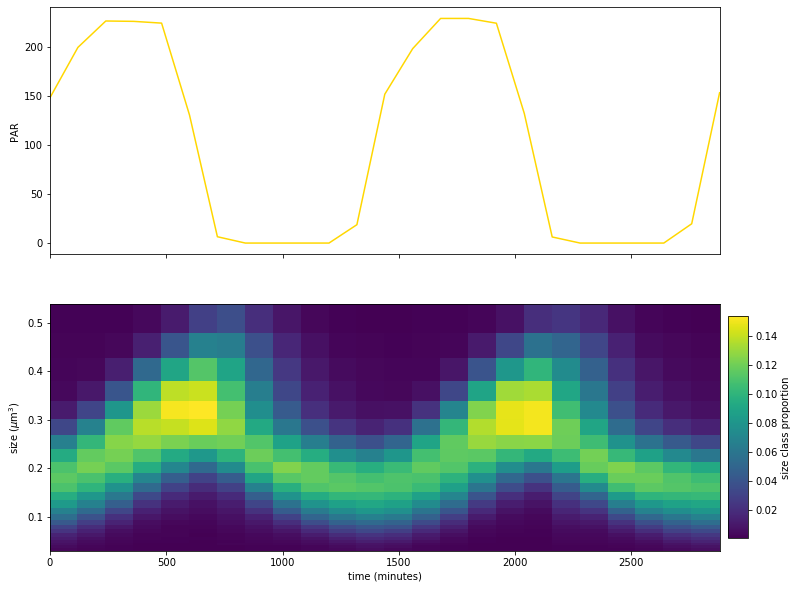

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

fig,axs = plt.subplots(nrows=2, sharex=True, figsize=(12,10))

ax = axs[0]
ax.plot(data_gridded['time'], data_gridded['PAR'], color='gold')
ax.set(ylabel='PAR')

ax = axs[1]
pc = ax.pcolormesh(data_gridded['time'],v,data_gridded['w_obs'])
ax.set(ylabel='size ($\mu$m$^3$)', xlabel='time (minutes)')
add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
None

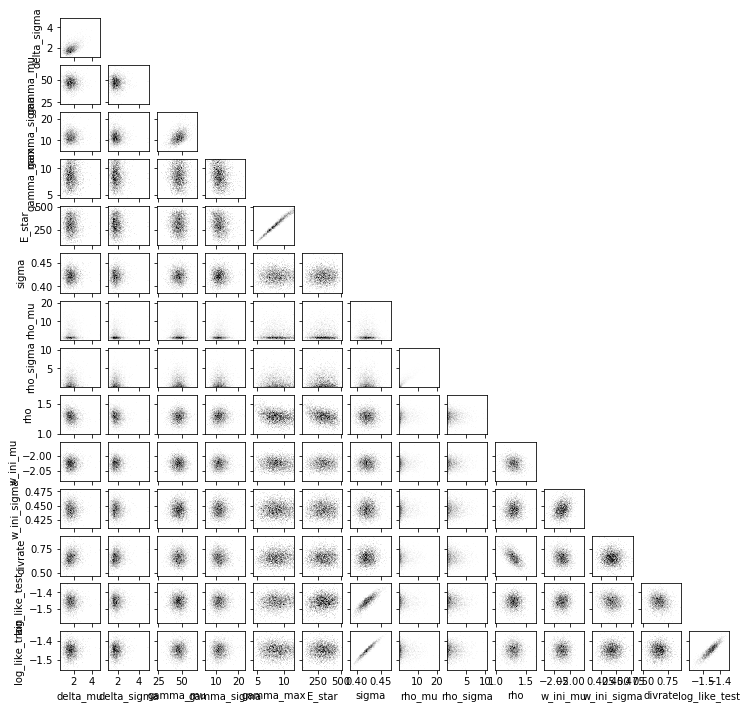

In [9]:
paramnames = [v for v in mcmc.flatnames if not v.startswith('mod_obspos') and not v.startswith('delta_max') and not '[' in v]
num_params = len(paramnames)

fig,axs = plt.subplots(num_params-1,num_params-1,sharex='col',sharey='row',figsize=(12,12), squeeze=False)
for ax in axs.flat:
    ax.set_visible(False)
for irow in range(1,num_params):
    for icol in range(irow):
        ax = axs[irow-1,icol]
        ax.set_visible(True)
        xname = paramnames[icol]
        yname = paramnames[irow]
        ax.hist2d(mcmc[xname],mcmc[yname],bins=50,cmap=mpl.cm.gray_r)
        if icol == 0:
            ax.set_ylabel(yname)
        if irow == num_params-1:
            ax.set_xlabel(xname)
None

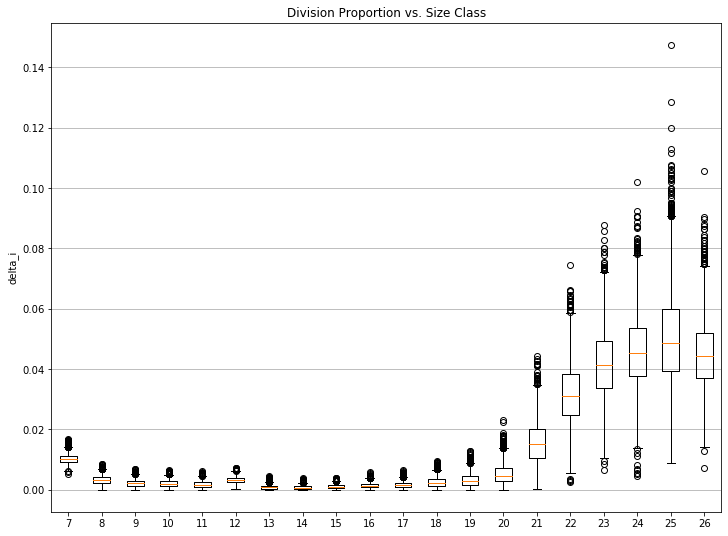

In [10]:
j = data_gridded['delta_v_inv'] + 1
m = data_gridded['m']

fig, axs = plt.subplots(nrows=1, sharex=True, figsize=(12,9))
ax = axs
ax.boxplot(mcmc['delta']*dt/1440, positions=range(j,m+1))
ax.set(ylabel='delta_i')
ax.yaxis.grid(True)
ax.title.set_text('Division Proportion vs. Size Class')

# ax = axs[1]
# ax.boxplot(mcmc['gamma_max']*dt/1440, positions=range(1,m))
# ax.set(ylabel='gamma_max')
# ax.yaxis.grid(True)

# ax = axs[2]
# ax.boxplot(mcmc['rho']*dt/1440, positions=range(1,m))
# ax.set(ylabel='rho')
# ax.yaxis.grid(True)

xlabels = [str(x) for x in range(1,m+1)]
None

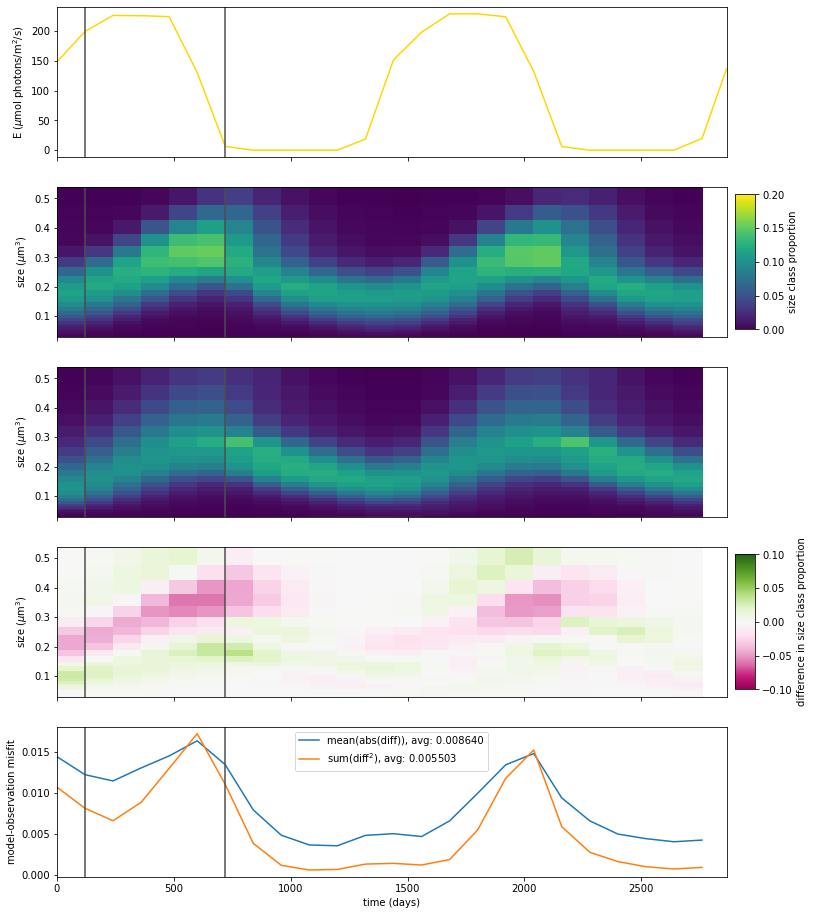

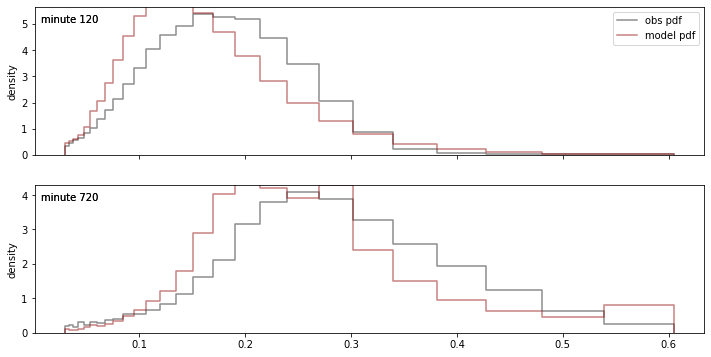

In [11]:
res = {'model':np.mean(mcmc['mod_obspos'], axis=0), 'obs':data['obs']}
colors = {'model':'darkred', 'obs':'0.1'}

res['model'] = res['model']/res['model'].sum(axis=0)
diff = res['model']-res['obs']

t = data['dt']*np.arange(data['nt'])
slice_indices = [1,6]
v_ext = data['v_min'] * 2**(np.arange(data['m']+1)*delta_v) 
v_width = v_ext[1:] - v_ext[:-1]

norm = mpl.colors.Normalize(0.0,0.2)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

fig,axs = plt.subplots(5,1,sharex=True,figsize=(12,16))

ax = axs[0]
ax.plot(t, data['E'], color='gold')
ax.set(xlim=(data['t_obs'][0],t[-1]), ylabel='E ($\mu$mol photons/m$^{2}$/s)')

ax = axs[1]
pc = ax.pcolormesh(data['t_obs'],v,res['obs'],norm=norm)
ax.set(ylabel='size ($\mu$m$^3$)')
add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

ax = axs[2]
ax.set(ylabel='size ($\mu$m$^3$)')
pc = ax.pcolormesh(data['t_obs'],v,res['model'],norm=norm)

ax = axs[3]
pc = ax.pcolormesh(data['t_obs'],v,diff,norm=norm_diff, cmap='PiYG')
ax.set(ylabel='size ($\mu$m$^3$)')
add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')

ax = axs[4]
prop = np.mean(np.abs(diff),axis=0)
ax.plot(data['t_obs'], prop, label='mean(abs(diff)), avg: {:.6f}'.format(np.mean(prop)))
prop = np.sum(diff**2,axis=0)
ax.plot(data['t_obs'], prop, label='sum(diff$^2$), avg: {:.6f}'.format(np.mean(prop)))
ax.set(xlabel='time (days)', ylabel='model-observation misfit')
ax.legend()

for ax in axs.flat:
    for i in slice_indices:
        ax.axvline(data['t_obs'][i], color='.3')

# plot slices

plotdata_y = np.zeros(2*(data['m']+1))

fig,axs = plt.subplots(nrows=len(slice_indices), sharex=True, figsize=(12,len(slice_indices)*3))
for i,ax in zip(slice_indices,axs.flat):
    for name in ('obs','model'):
        color = colors[name]
        cdata = res[name][:,i]
        plotdata_y[1:-1] = np.repeat(cdata/v_width,2)
        ax.plot(np.repeat(v_ext,2), plotdata_y, color=color, alpha=0.5, label='{} pdf'.format(name))
        ax.text(0.01, 0.95, 'minute {}'.format(data['t_obs'][i]), transform=ax.transAxes, va='top', ha='left')
        ax.set_ylabel('density')
        ax.set_ylim(bottom=0.0)
axs[0].legend()
None